##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Introduction to word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Introduction to Word Embeddings

... introductory text goes here ...

# Embeddings Tutorial

In [3]:
from tensorflow import keras

from keras.layers import Embedding

Using TensorFlow backend.


We will learn an embedding using an Embedding layer which takes in two parameters, the first being the maximum number of tokens (our vocubulary size), and the second being the number of dimensions of the embeddings. An example follows below.

In [4]:
VOCAB_SIZE = 1000
EMBED_SIZE = 64

# create an embedding layer
embedding_layer = Embedding(VOCAB_SIZE, EMBED_SIZE)

The Embedding layer provides a mapping from a one-hot vector to a dense vector. It essentially serves as a dictionary lookup.

The input to the Embedding layer is a 2D tensor of integers, of shape (samples, sequence_length). All the sequences in a batch must be of the same length. Sequences that are shorter than `sequence_length` should be padded with zeros, while sequences that are longer should be truncated.

The output of the Embedding layer is a 3D tensor of floating point numbers, of shape (samples, sequence_length, embedding_dimensionality). This output can be processed by an RNN layer or a 1D convolution layer.

When an Embedding layer is instantiated, its weights are randomly assigned. During training, these word vectors are gradually adjusted through backpropagation.

We will make use of the IMDB movie reviews dataset to train a classifier. We will restrict the movie reviews to the top 10,000 most common words, and cut the reviews after only 20 words. Our network will learn an 8-dimensional embedding for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

In [5]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
VOCAB_SIZE = 10000

# maximum number of words to use in a sequence
EMBED_SIZE = 20

# load IMDB dataset as lists of integers
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words= VOCAB_SIZE)

# convert our lists of integers into 2D tensors
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=EMBED_SIZE)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=EMBED_SIZE)

NameError: name 'X_test' is not defined

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

DIM = 8

# create a Sequential model
model = Sequential()
# lets add our Embedding layer
model.add( Embedding(VOCAB_SIZE, DIM, input_length= EMBED_SIZE) )

# our output is a 3D tensor of shape (samples, VOCAB_SIZE, EMBED_SIZE)
# we will flatten it into a 2D tensor of shape (samples, VOCAB_SIZE * EMBED_SIZE)
model.add( Flatten() )

# Let's add a classifier.
model.add( Dense(1, activation='sigmoid') )
model.compile( optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'] )

model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Our classifier has a validation accuracy of about 76%. Note that we make use of only the first 20 words in each review. We are also flattening our embedding and passing it to a single Dense layer, which treats each word separately without taking into consideration the ordering of the words in the sequence.

It would be much better to use a recurrent layer or 1D convolution which will take the sequence of the words into consideration.

# Pre-trained Word Embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras Embedding layer. Word2Vec is one of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Create Word Embeddings from Raw Text
In this section, we will download the IMDB dataset and use that to create our word embeddings.

### Download the IMDB data as raw text
First, head to http://ai.stanford.edu/~amaas/data/sentiment/ and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Uncompress it.



In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

Let's expand the archive

In [ ]:
!tar -zxvf aclImdb_v1.tar.gz

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels (positive / negative) into a labels list:

In [6]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
!ls

### Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split. We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 samples. So we will be learning to classify movie reviews after looking at just 200 examples...

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

EMBED_SIZE = 100 # we will limit reviews to 100 words
TRAIN_SAMPLES = 200 # we will train on 200 samples
VAL_SAMPLES = 10000 # we will validate on 10,000 samples
VOCAB_SIZE = 10000 # we will consider the top 10,000 words

tokenizer = Tokenizer(num_words= VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

data = pad_sequences(sequences, maxlen=EMBED_SIZE)

labels = np.asarray(labels)
print('Shape of data tensor: {}'.format(data.shape))
print('Shape of label tensor: {}'.format(labels.shape))

# Let's shuffle our data
indices = np.arange( data.shape[0] )
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Let's create our training and validation sets
X_train = data[:TRAIN_SAMPLES]
y_train = data[:TRAIN_SAMPLES]

X_val = data[TRAIN_SAMPLES: TRAIN_SAMPLES + VAL_SAMPLES]
y_val = data[TRAIN_SAMPLES: TRAIN_SAMPLES + VAL_SAMPLES]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings

Head to https://nlp.stanford.edu/projects/glove/ (where you can learn more about the GloVe algorithm), and download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). Un-zip it.

In [ ]:
!pip install wget

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

Notice that the four text files were unzipped into our working directory.

In [8]:
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now let's build an embedding matrix that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, 
embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization). Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.

In [9]:
embedding_dim = 100

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim)) #create an array of zeros with VOCAB_SIZE rows and embedding_dim columns
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < VOCAB_SIZE:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model
We will use the same architecture as we did when we built our own embedding

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_dim, input_length=EMBED_SIZE))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings into the model
The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Let's just load the GloVe matrix we prepared into our Embedding layer, the first layer in our model:

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, we freeze the embedding layer (we set its trainable attribute to False), following the same rationale as what you are already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our Embedding layer), and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Train and Evaluate
Let's compile our model and train it:

In [16]:
# load IMDB dataset as lists of integers
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words= VOCAB_SIZE)

# convert our lists of integers into 2D tensors
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=EMBED_SIZE)
X_valid = preprocessing.sequence.pad_sequences(X_valid, maxlen=EMBED_SIZE)

You need `h5py` to save the weights of your model.

In [ ]:
!pip install h5py

In [17]:
import h5py

In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save_weights('./pre_trained_glove_model.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 8s 335us/step - loss: 0.7166 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 2/10
25000/25000 [==============================] - 9s 341us/step - loss: 0.6903 - acc: 0.5351 - val_loss: 0.7013 - val_acc: 0.5226
Epoch 3/10
25000/25000 [==============================] - 8s 320us/step - loss: 0.6634 - acc: 0.6025 - val_loss: 0.6828 - val_acc: 0.5638
Epoch 4/10
25000/25000 [==============================] - 8s 323us/step - loss: 0.6324 - acc: 0.6444 - val_loss: 0.6995 - val_acc: 0.5675
Epoch 5/10
25000/25000 [==============================] - 8s 322us/step - loss: 0.5963 - acc: 0.6831 - val_loss: 0.7263 - val_acc: 0.5699
Epoch 6/10
25000/25000 [==============================] - 8s 326us/step - loss: 0.5647 - acc: 0.7112 - val_loss: 0.7423 - val_acc: 0.5528
Epoch 7/10
25000/25000 [==============================] - 8s 328us/step - loss: 0.5341 - acc: 0.7373 - val_loss: 0.7807 - 

##### Let's plot it's performance over time

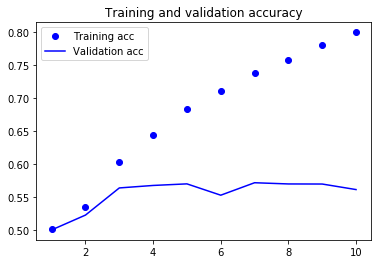

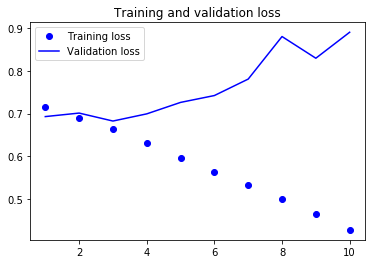

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the sake of the exercise (in real life you don't get to pick your training data).

### Train Embedding Layer

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_dim, input_length=EMBED_SIZE))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 22s 894us/step - loss: 0.4208 - acc: 0.7957 - val_loss: 0.3515 - val_acc: 0.8433
Epoch 2/10
25000/25000 [==============================] - 25s 1ms/step - lo

Let's plot the performance once more

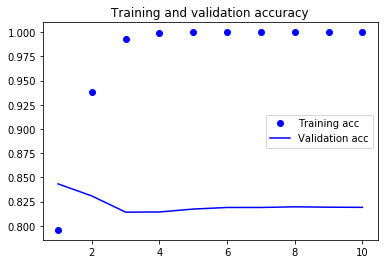

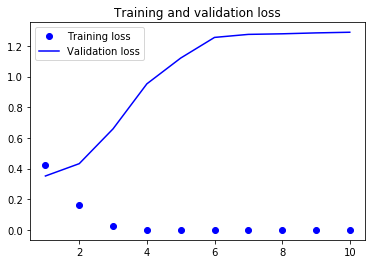

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [22]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=EMBED_SIZE)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [23]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 106us/step


[0.9952261981010437, 0.49976]

Our training accuracy is only 49% because of the small amount of data that we have.

# Closing Advice